In [13]:
using divand
using PyPlot
using NetCDF
using PyCall
using StatsBase
using GridInterpolations
@pyimport numpy.ma as ma
using NullableArrays
using DataArrays
using NaNMath
nm=NaNMath
@pyimport mpl_toolkits.basemap as basemap
@pyimport matplotlib.colors as matcolors

fname = "/home/flo/R/TFE/tfe/FINAL_CHECK.txt"
#fname = "/home/flo/R/TFE/tfe/FULLTOTAL.txt"
bathname = "/home/flo/R/TFE/tfe/gebco_30sec_16_FLORIAN.nc"
isglobal = false

function load(fname)

        data = readlines(open(fname,"r"))
        nobs = length(data)
        lon = zeros(nobs)
        lat = zeros(nobs)
        sigma = zeros(nobs)
        depth = zeros(nobs)
        doy = zeros(nobs)
        day = zeros(nobs)
        month = zeros(nobs)
        year = zeros(nobs)
        juld = zeros(nobs)
        season = zeros(nobs)
        category = zeros(nobs)

   for i in 1:nobs
        rec = split(data[i])
        lon[i] = parse(Float64,rec[1])
        lat[i] = parse(Float64,rec[2])
        juld[i] = parse(Float64,rec[3])
        sigma[i] = parse(Float64,rec[4])
        doy[i] = parse(Float64,rec[5])
        year[i] = parse(Float64,rec[6])
        month[i] = parse(Float64,rec[7])
        day[i] = parse(Float64,rec[8])
        depth[i] = parse(Float64,rec[11])
        season[i] = parse(Float64,rec[12])
       
    end

    return lon, lat, juld, sigma, depth, doy, year, month, day, season
end


lon, lat, juld, sigma, depth, doy, year, month, day, season = load(fname)

data = depth
name = "depth"

################
# BACKGROUND 0 #
################

dx = dy = 0.05#spatial resolution
#dx = dy = 0.1
lonr = 27.:dx:42
latr = 40.:dy:47

#mask creation
mask,(pm,pn),(xi,yi) = divand_rectdom(lonr,latr)

#use of land-sea mask 
mxi,myi,mask2 = load_mask(bathname,isglobal,Vector(lonr),Vector(latr),1)

#BACKGROUND 0 i.e. B0 => MEAN OF ALL DATA (FROM JANUARY TO DECEMBER)
b0 = mean(data)
a0 = data-b0 #compute anomalies (compared to background hence reference field)

INFO: Creating land-sea mask on level: 1
INFO: Extracting bathymetry from file: /home/flo/R/TFE/tfe/gebco_30sec_16_FLORIAN.nc


317-element Array{Float64,1}:
  -6.07733 
  -6.76566 
  -4.3207  
 -10.6244  
 -17.4265  
  -9.50942 
   0.886045
  -7.19417 
  -0.385005
  -5.09998 
 -10.5346  
   2.43535 
   7.51781 
   ⋮       
  -0.408363
  -5.75811 
  -3.81024 
  -8.5203  
  -3.50927 
  -3.52699 
  -5.91731 
 -13.7145  
  -5.19966 
  -4.15919 
  -5.60609 
 -10.2186  

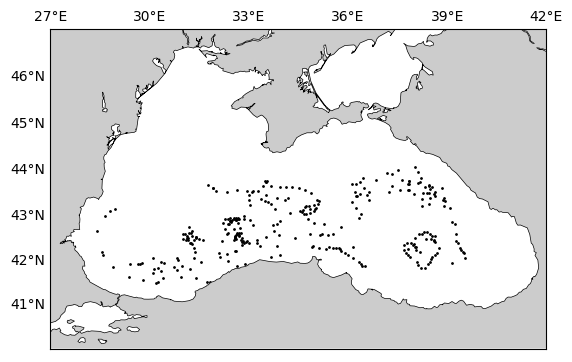

PyObject <matplotlib.collections.PathCollection object at 0x7fde6c4b5110>

In [14]:
map = basemap.Basemap(llcrnrlon=27, llcrnrlat=40,
    urcrnrlon=42, urcrnrlat=47,
    resolution="i", projection="merc")
map[:drawcoastlines](linewidth=0.5);
map[:fillcontinents]();
#map[:drawmapboundary]()
map[:drawmeridians](collect(27:3:42), labels=[0,0,1,0], linewidth=0)
map[:drawparallels](collect(40:1:48), labels=[1,0,0,0], linewidth=0)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
x,y  = map(lon,lat)
scatter(x,y,1,"black")

In [15]:
#ONLY KEEP VALUES FROM MARCH TO OCTOBER
m = (month .> 2) .& (month .<11)
lat = lat[m]
lon = lon[m]
juld = juld[m]
sigma = sigma[m]
depth = depth[m]
doy = doy[m]
year = year[m]
month = month[m]
day = day[m]
season = season[m]
a0 = a0[m]
data = data[m]

305-element Array{Float64,1}:
 23.2938
 33.6892
 25.609 
 32.4182
 27.7032
 22.2686
 35.2385
 40.321 
 26.1358
 32.5545
 28.3425
 38.8032
 29.1558
  ⋮     
 33.9006
 37.8208
 28.2321
 25.0465
 24.0891
 27.5882
 28.6125
 32.3948
 27.0451
 28.9929
 24.2829
 29.2939

In [16]:
#=
#screening
#2D analysis

epsilon2 = [0.001,0.01,0.1,0.3,0.5,1,2,3,5,10]
lenx = leny = [0.01,0.1,0.2,0.5,1,3,5,10,20,50]
    
#version 4D
@pyimport matplotlib.animation as anim


fig = figure()
ax = axes()

x = 27:0.1:42
y = 40:0.1:47

function plotfig(i,j,epsilon2,lenx,leny)
    clf()
        eps = epsilon2[i]
        space = lenx[j]
        xlim(27,42)
        ylim(40,47)
        fi,s = divandgo(mask2,(pm,pn),(xi,yi),(lon,lat),a0,(lenx[j],leny[j]),epsilon2[i])
        title("\$eps2 = $eps\$ and \$len=$space\$")
        hold(true)
        pcolor(xi,yi,fi+b0);colorbar()
        clim(27,38)#attention à l'ordre, clim après le scatter -> marche pas
        scatter(lon,lat,1,data)  
        #axes()[:set_aspect]("equal") 
        
end


withfig(fig) do
    for k in 1:length(epsilon2)
        for l in 1:length(lenx)
            plotfig(k,l,epsilon2,lenx,leny)
            savefig(@sprintf("/home/flo/R/TFE/tfe/GRAPHS/SCREENING_BACKGROUND/test_%04d_%04d",k,l), bbox_inches="tight"); 
        end
    end
end
=#

In [17]:
#GROSS ANALYSIS
lenx = leny = 5
eps2 = 2
fi,erri,a1,~,scalefactore = divandgo(mask2,(pm,pn),(xi,yi),(lon,lat),a0,(lenx,leny),eps2,:cpme)
a1 = a1 + b0
b1 = fi + b0
#b1_save = copy(b1)

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


301×141 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  Na

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


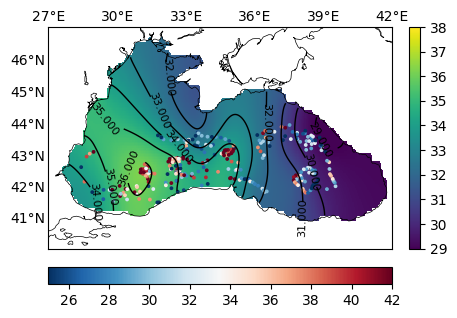

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


PyObject <matplotlib.colorbar.Colorbar object at 0x7fde6c90b710>

In [18]:
#GROSS ANALYSIS
lenx = leny = 5
eps2 = 2
fi,erri,a1,~,scalefactore = divandgo(mask2,(pm,pn),(xi,yi),(lon,lat),a0,(lenx,leny),eps2,:cpme)
a1 = a1 + b0
b1 = fi + b0
#b1_save = copy(b1)

x, y = map(xi, yi)
fi[erri .> 1] = NaN;#control error field
map[:pcolormesh](x, y, fi+b0);
map[:drawcoastlines](linewidth=0.5);
# Draw lat/lon grid lines every 30 degrees.
map[:drawmeridians](collect(27:3:42), labels=[0,0,1,0], linewidth=0)
map[:drawparallels](collect(40:1:48), labels=[1,0,0,0], linewidth=0)
colorbar(clim(29,38), pad = 0.035, fraction = 0.2725, shrink = 0.60)
cs = map[:contour](x, y, fi+b0, 8, linewidths=1, colors="k")   #, levels = [29:1:35])
clabel(cs, fontsize = 8)
lambda = 1/eps2
#title("Depth background with \$λ = $lambda\$ and \$L=$lenx\$")
x2,y2 = map(lon,lat)
#scatter(x2,y2,3,year;cmap = mycmap) 
scatter(x2,y2,3,data; cmap=ColorMap("RdBu_r"));colorbar(clim(25,42), orientation="horizontal", pad = 0.05)
#savefig("/home/flo/R/TFE/tfe/GRAPHS/DIVAND/DEPTH/smooth_background_contour_depth.pdf")

In [35]:
#PSEUDO-SEASONAL ANALYSIS
function pseudo_season(period)#a vector of months to keep
    index = find( x -> (x in period), month)
    nlat = lat[index]
    nlon = lon[index]
    ndoy = doy[index]
    nsigma = sigma[index]
    ndepth = depth[index]
    nyear = year[index]
    na1 = a1[index]
    ndata = data[index]
    
    return index, nlat, nlon, ndoy, nsigma, ndepth, nyear, na1, ndata
end

pseudo_season (generic function with 1 method)

In [ ]:
period = [3,4]
index, nlat, nlon, ndoy, nsigma, ndepth, nyear, na1, ndata = pseudo_season(period)
lenx = leny = 1
#bestfactorl,bestfactore = divand_cv(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,1,10,3);
eps2 = 0.5
fi2,erri2,a2,~,~ = divandgo(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,:cpme)
x, y = map(xi, yi)
fi3 = copy(fi2)
erri3 = copy(erri2)
error_field = 0.5#no data excluded
fi3[erri3 .> error_field] = NaN;#control error field
map[:pcolormesh](x, y, fi3+b1);
map[:drawcoastlines](linewidth=0.5);
# Draw lat/lon grid lines every 30 degrees.
#map[:drawmeridians](collect(27:3:42), linewidth=.25)
#map[:drawparallels](collect(40:1:48), linewidth=.25)
colorbar(clim(29,38), pad = 0.035, fraction = 0.2725, shrink = 0.60)
cs = map[:contour](x, y, fi3+b1, 7, linewidths=1, colors="k")   #, levels = [29:1:35])
clabel(cs, fontsize = 8)
#title("MARS-APRIL / \$eps2 = $eps2\$ / \$len=$lenx\$ / \$error = $error_field\$")
x2,y2 = map(nlon,nlat)
#scatter(x2,y2,3,nyear;cmap =mycmap)
scatter(x2,y2,3,ndata; cmap=ColorMap("RdBu_r"));colorbar(clim(25,42), orientation="horizontal", pad = 0.05)
savefig("/home/flo/R/TFE/tfe/GRAPHS/DIVAND/DEPTH/mars_april_depth_contour.pdf")

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix


INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


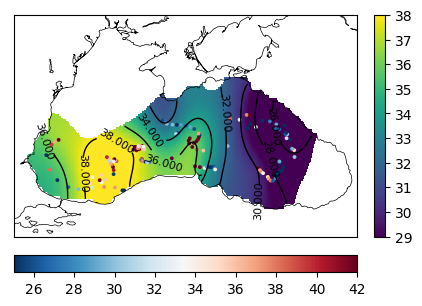

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


In [46]:
period = [5,6,7]
index, nlat, nlon, ndoy, nsigma, ndepth, nyear, na1, ndata = pseudo_season(period)
lenx = leny = 1
#bestfactorl,bestfactore = divand_cv(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,1,10,3);
eps2 = 0.5
fi2,erri2,a2,~,~ = divandgo(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,:cpme)
x, y = map(xi, yi)
fi3 = copy(fi2)
erri3 = copy(erri2)
error_field = 0.5#no data excluded
fi3[erri3 .> error_field] = NaN;#control error field
map[:pcolormesh](x, y, fi3+b1);
map[:drawcoastlines](linewidth=0.5);
# Draw lat/lon grid lines every 30 degrees.
#map[:drawmeridians](collect(27:3:42), linewidth=.25)
#map[:drawparallels](collect(40:1:48), linewidth=.25)
colorbar(clim(29,38), pad = 0.035, fraction = 0.2725, shrink = 0.60)
cs = map[:contour](x, y, fi3+b1, 7, linewidths=1, colors="k")   #, levels = [29:1:35])
clabel(cs, fontsize = 8)
#title("MARS-APRIL / \$eps2 = $eps2\$ / \$len=$lenx\$ / \$error = $error_field\$")
x2,y2 = map(nlon,nlat)
#scatter(x2,y2,3,nyear;cmap =mycmap)
scatter(x2,y2,3,ndata; cmap=ColorMap("RdBu_r"));colorbar(clim(25,42), orientation="horizontal", pad = 0.05)
savefig("/home/flo/R/TFE/tfe/GRAPHS/DIVAND/DEPTH/may_july_depth_contour.pdf")

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving
INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


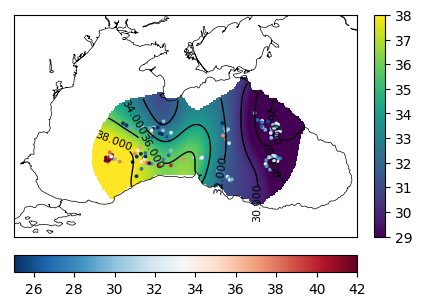

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...
INFO: Done solving


In [41]:
period = [8,9,10]
index, nlat, nlon, ndoy, nsigma, ndepth, nyear, na1, ndata = pseudo_season(period)
lenx = leny = 1
#bestfactorl,bestfactore = divand_cv(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,1,10,3);
eps2 = 0.5
fi2,erri2,a2,~,~ = divandgo(mask2,(pm,pn),(xi,yi),(nlon,nlat),ndata-na1,(lenx,leny),eps2,:cpme)
x, y = map(xi, yi)
fi3 = copy(fi2)
erri3 = copy(erri2)
error_field = 0.5#no data excluded
fi3[erri3 .> error_field] = NaN;#control error field
map[:pcolormesh](x, y, fi3+b1);
map[:drawcoastlines](linewidth=0.5);
# Draw lat/lon grid lines every 30 degrees.
#map[:drawmeridians](collect(27:3:42), linewidth=.25)
#map[:drawparallels](collect(40:1:48), linewidth=.25)
colorbar(clim(29,38), pad = 0.035, fraction = 0.2725, shrink = 0.60)
cs = map[:contour](x, y, fi3+b1, 7, linewidths=1, colors="k")   #, levels = [29:1:35])
clabel(cs, fontsize = 8)
#title("MARS-APRIL / \$eps2 = $eps2\$ / \$len=$lenx\$ / \$error = $error_field\$")
x2,y2 = map(nlon,nlat)
#scatter(x2,y2,3,nyear;cmap =mycmap)
scatter(x2,y2,3,ndata; cmap=ColorMap("RdBu_r"));colorbar(clim(25,42), orientation="horizontal", pad = 0.05)
savefig("/home/flo/R/TFE/tfe/GRAPHS/DIVAND/DEPTH/august_october_depth_contour.pdf")

In [49]:
std(ndata)

8.0397088532139